In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from scipy import stats
import cm50268_lab1_setup as lab1
import cm50268_lab2_setup as lab2

In [2]:
#Load up datasets
train = np.genfromtxt('ee-train.csv', delimiter=',')
test = np.genfromtxt('ee-test.csv', delimiter=',')
train = np.delete(train, 0, 0)
test = np.delete(test, 0, 0)
x_test = test[:,:-1]
x_train = train[:,:-1]
y_train = train[:,-1:]
y_test = test[:,-1:]

In [3]:
mu_x_train = np.mean(x_train, axis = 0)
std_x_train = np.std(x_train, axis = 0)

mu_x_test = np.mean(x_test, axis = 0)
std_x_test = np.std(x_test, axis = 0)

x_train_norm = (x_train - mu_x_train)/std_x_train
x_train_norm = np.hstack((np.ones((len(x_train_norm), 1)), x_train_norm))

x_test_norm = (x_test - mu_x_train)/std_x_train
x_test_norm = np.hstack((np.ones((len(x_test_norm), 1)), x_test_norm))

In [4]:
len(x_train)

384

# Task 1

In [5]:
train_df = pd.DataFrame(train)
mean_train = []
for i in range(len(train_df.columns)-1):
    train_temp = train_df[[i,8]] 
    mean_train.append(train_temp.groupby([i]).mean().to_numpy().flatten())
mean_train = np.array(mean_train)



In [6]:
mean_train = []
for i in range(len(train_df.columns)-1):
    train_temp = train_df[[i,8]] 
    mean_train.append(train_temp.groupby([i]).mean().to_numpy().flatten())
mean_train = np.array(mean_train)

In [7]:
df_train = pd.read_csv('ee-train.csv')
col_names = df_train.columns

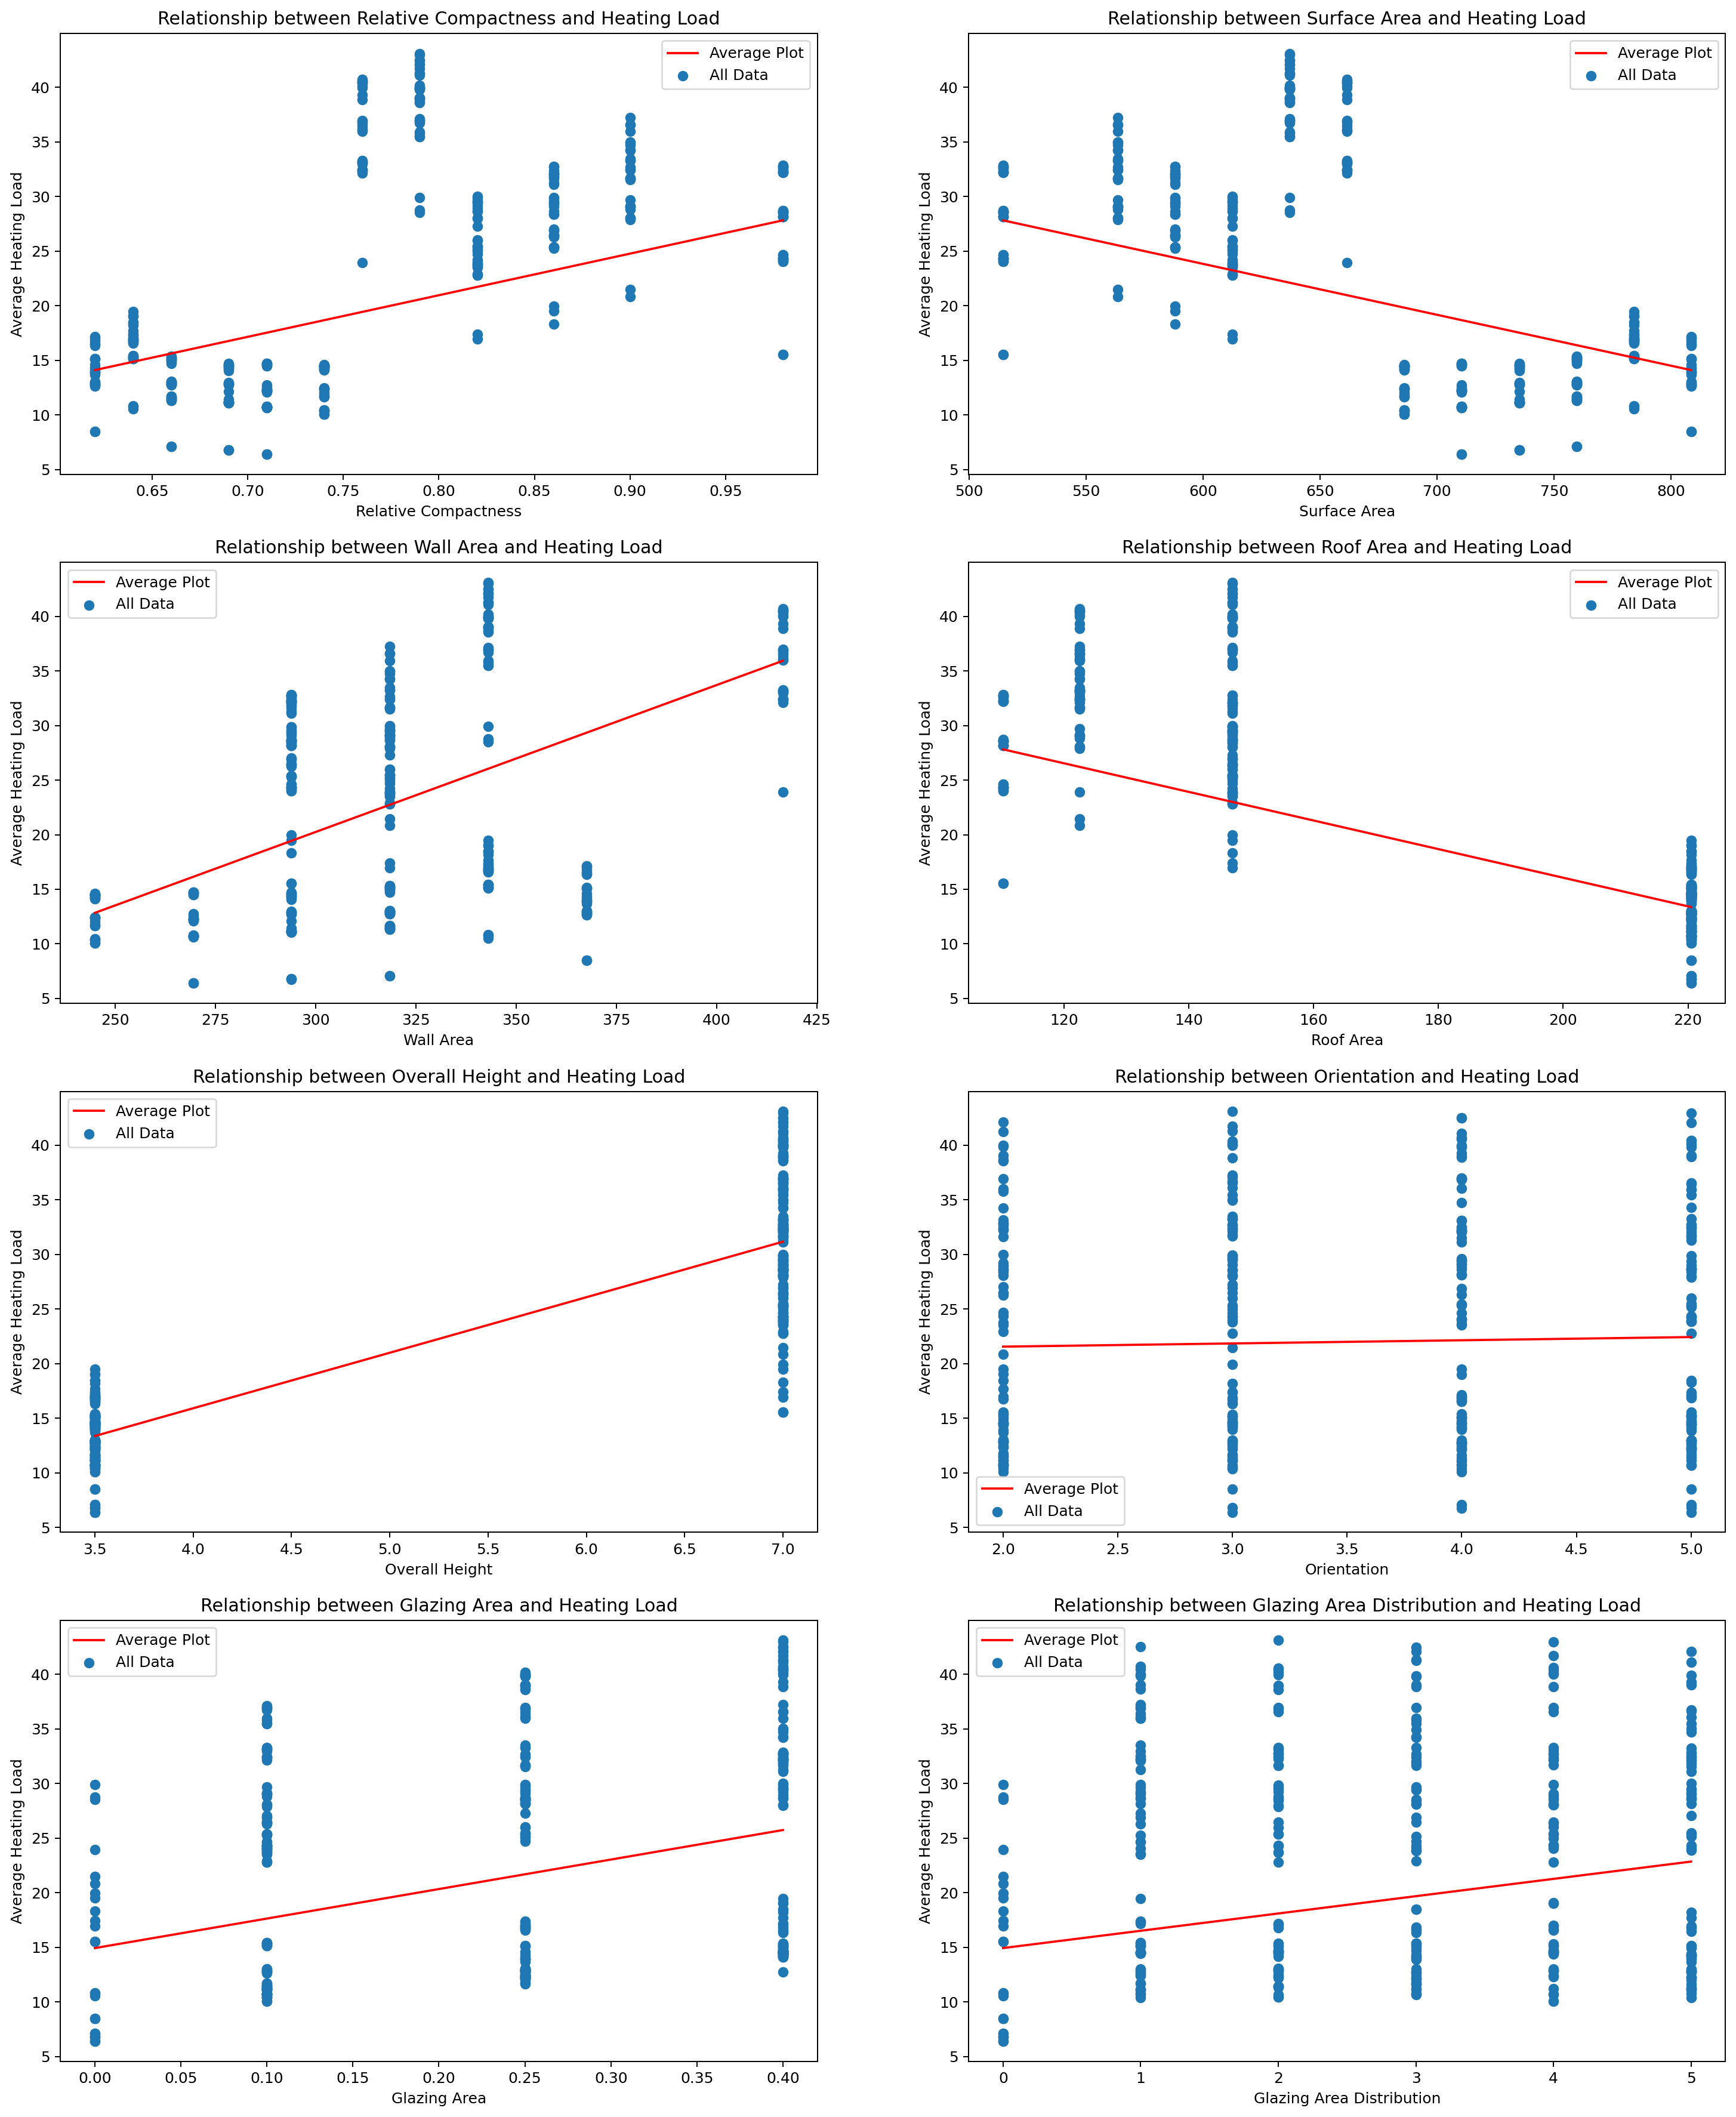

In [8]:
fig = plt.figure(figsize=(20,25), dpi=180)
count = 0 
for a, j in enumerate(mean_train):
    count += 1
    fig.add_subplot(4,2,count)
    plt.scatter(x_train[:,a], y_train, label='All Data')
    plt.plot([np.unique(x_train[:,a])[0], np.unique(x_train[:,a])[-1]] , [j[0], j[-1]], label='Average Plot', color='r')
    plt.legend()
    plt.title('Relationship between %s and Heating Load' %col_names[a]) 
    plt.xlabel(col_names[a])
    plt.ylabel('Average Heating Load')
plt.savefig('Correlations')
plt.show()

Glazing Area, Overall Height and Roof Area have the clearest relationship with Heating Load
Data is pretty linear no across most features so shoudnt really produce that much error.



In [9]:
reg = linear_model.LinearRegression()
a = reg.fit(x_train_norm, y_train)
y_pred_train = a.predict(x_train_norm)
y_pred_test = a.predict(x_test_norm)
print(a.coef_, a.intercept_)

[[ 0.00000000e+00 -7.47417549e+00  2.34959076e+14 -1.12552716e+14
  -2.38976727e+14  7.11600768e+00 -6.72881467e-02  2.71662911e+00
   1.86726982e-01]] [23.06008459]


In [10]:
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('Train error:', rmse_train)
print('Test error:', rmse_test)

Train error: 3.0284574881804245
Test error: 2.8455939340640133


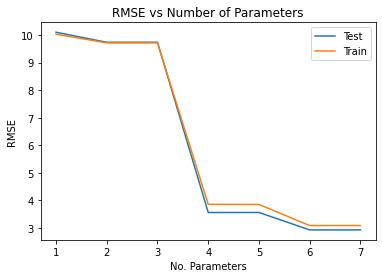

In [11]:
test_errors = []
train_errors = []
x_coords = []

for e in range(1, len(train[0])-1):
    model = reg.fit(x_train[:,e:], y_train)
    y_pred_train = reg.predict(x_train[:,e:])
    y_pred_test = reg.predict(x_test[:,e:])
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_errors.append(rmse_test)
    train_errors.append(rmse_train)
    x_coords.append(e)

x_coords = list(reversed(x_coords))

plt.plot(x_coords, test_errors, label='Test')
plt.plot (x_coords, train_errors, label='Train')
plt.legend()
plt.xlabel('No. Parameters')
plt.ylabel('RMSE')
plt.title('RMSE vs Number of Parameters')
plt.show()



# Task 2

In [12]:
N_train = len(x_train)
N_val = N_train
N_test = len(x_test)

sigma = 0.1
s2 = sigma**2

In [13]:
x_train_norm.shape

(384, 9)

In [14]:
def compute_log_marginal(PHI, t, alph, s2):
    #
    # Exploit the shape of C and the fact that M < N (usually)
    #
    N, M = PHI.shape
    beta = 1 / s2
    Mu, SIGMA = compute_posterior(PHI, t, alph, s2)
    #
    # Constant factor
    #
    logML = -N * np.log(2 * np.pi)
    #
    # log determinant factor (log|C|)
    #
    # If SIGMA becomes singular, sgn<0
    #
    sgn, logdet = np.linalg.slogdet(SIGMA)
    #
    if sgn < 0:
        print("Error with alpha={0}, s2={1}".format(alph, s2))
        raise np.linalg.LinAlgError("logdet sign is negative - something is wrong!")
    #
    logML += logdet + N*np.log(beta) + M*np.log(alph)
    #
    # data term (t'Ct)
    #
    logML -= beta * (t.T @ (t - PHI @ Mu))
    #
    logML = logML[0, 0] / 2.0
    #
    return logML

def compute_posterior(PHI, t, alph, s2):
    M = PHI.shape[1]
    beta = 1/s2
    H = beta*(PHI.T @ PHI) + alph*np.eye(M)
    SIGMA = np.linalg.inv(H)
    Mu = beta * (SIGMA @ (PHI.T @ t))
    #
    return Mu, SIGMA

In [15]:
log_alph = np.linspace(-4, 4, 50)
log_s2 = np.linspace(-4, 4, 50)

alph = 10**log_alph
s2 = 10**log_s2

a_mesh, s2_mesh = np.meshgrid(log_alph, log_s2)
z = np.zeros(a_mesh.shape)

for j, a in enumerate(alph):  
    for i, sig in enumerate(s2):
        z[j,i] = lab2.compute_log_marginal_scipy(x_train_norm, y_train, a, sig)

In [16]:
coords_ = np.unravel_index(z.reshape(50,50).argmax(), (50,50))
opt_alph = alph[coords_[0]]
opt_s2 = s2[coords_[1]]

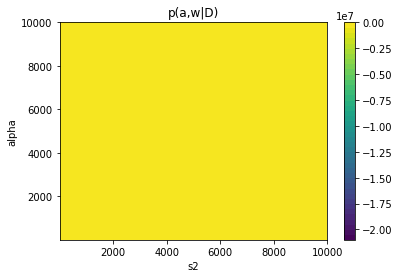

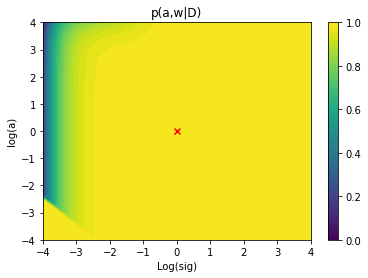

Most probable alpha: 0.0029470517025518097
Most probable s2: 0.0001


In [17]:
plt.contourf(s2, alph, z.reshape(50, 50), 50)
plt.colorbar()
plt.title('p(a,w|D)')
plt.xlabel('s2')
plt.ylabel('alpha')
plt.show()
plt.contourf(log_alph, log_s2, z.reshape(50,50), 50)
plt.title('p(a,w|D)')
plt.xlabel('Log(sig)')
plt.ylabel('log(a)')
plt.scatter(alph[coords_[0]], alph[coords_[1]], marker='x', c='r')
plt.colorbar()
plt.savefig('Posterior gird search')
plt.show()

print('Most probable alpha:', alph[coords_[0]])
print('Most probable s2:', alph[coords_[1]])

In [65]:
mu_w, sig_w = compute_posterior(x_train_norm, y_train, opt_alph, opt_s2)
bayes_error_test = np.sqrt(np.mean((x_test_norm @ mu_w - y_test)**2))
bayes_error_train = np.sqrt(np.mean((x_train_norm @ mu_w - y_train)**2))
print('RMSE for test data with alpha = {} and s2 = {} is:'.format(opt_alph, opt_s2), bayes_error_test)
print('RMSE for train data with alpha = {} and s2 = {} is:'.format(opt_alph, opt_s2), bayes_error_train)
mu_w


RMSE for test data with alpha = 0.0029470517025518097 and s2 = 0.0001 is: 2.8435880118012307
RMSE for train data with alpha = 0.0029470517025518097 and s2 = 0.0001 is: 3.0115517876503963


array([[22.92070311],
       [-7.23462527],
       [-3.94214876],
       [ 0.75594959],
       [-4.23191581],
       [ 7.20395149],
       [-0.12516927],
       [ 2.77021895],
       [ 0.20406264]])

In [19]:
# alpha_estimate = a_/b_
# beta_estimate = c_/d_
# mu = beta_estimate * (SIGMA @ x_train_norm.T @ y_train)
# SIGMA = np.linalg.inv(beat_estimate * (x_train_norm.T @ x_train_norm) + alpha_estimate * np.eye(x_train_norm.shape[1]))
# w_T_w = (mu.T@mu)[0,0] + np.trace(SIGMA)
# a_ = a_ + 0.5
# b_ = b_ + (0.5 * w_T_w)
# c_ = c_ + (len(x_train)/2)
# d_ = d_ + 0.5*sum((y_train - x_train_norm@mu))

In [22]:
# q_sig_e = 0.1
# q_sig_w = 0.1
mu = np.linspace(0, 1, 9).reshape(9,1)
SIGMA = np.linspace(0, 0.1, 9).reshape(1,9)
a_ = 1e-16
b_ = 1e-16
c_ = 1e-16
d_ = 1e-16

mu_track = []
log_track = []
alpha_beta_track = []
N, M = x_train_norm.shape
converged = False
count = 0

while not converged:
    
    alpha_estimate = a_/b_
    beta_estimate = c_/d_
    alpha_beta_track.append(tuple((alpha_estimate,beta_estimate)))
    log_track.append(lab2.compute_log_marginal_scipy(x_train_norm, y_train, alpha_estimate, beta_estimate))
    w_T_w = (mu.T @ mu)[0,0] + np.trace(SIGMA)
    
    mu_track.append(mu)
    SIGMA = np.linalg.inv(beta_estimate * (x_train_norm.T @ x_train_norm) + alpha_estimate * np.eye(x_train_norm.shape[1]))
    mu = beta_estimate * (SIGMA @ (x_train_norm.T @ y_train))
    
    
    
    a_ = a_ + 0.5*M
    b_ = b_ + (0.5 * w_T_w)
    c_ = c_ + 0.5*N
    d_ = d_ + 0.5*sum((y_train - x_train_norm @ mu)**2)[0]
     
#     print(sum(mu_track[count]) - sum(mu))
    if abs(sum(mu_track[count]) - sum(mu)) < 1e-6:
        converged = True
        print('converged after', count, 'iterations')
    else:
        count += 1


converged after 1597 iterations


In [66]:
mu


array([[22.9142342 ],
       [-6.93298157],
       [-3.73496184],
       [ 0.80393958],
       [-4.0508077 ],
       [ 7.29403669],
       [-0.12604073],
       [ 2.77118053],
       [ 0.20277568]])

In [23]:
mean_field_error_train = np.sqrt(np.mean((x_train_norm @ mu - y_train)**2))
mean_field_error_test = np.sqrt(np.mean((x_test_norm @ mu - y_test)**2))
print('RMSE for test data with alpha = {} and s2 = {} is:'.format(alpha_estimate, beta_estimate), mean_field_error_test)
print('RMSE for train data with alpha = {} and s2 = {} is:'.format(alpha_estimate, beta_estimate), mean_field_error_train)

RMSE for test data with alpha = 0.011949038741180229 and s2 = 0.11022372706770484 is: 2.843435453684814
RMSE for train data with alpha = 0.011949038741180229 and s2 = 0.11022372706770484 is: 3.011694687238721


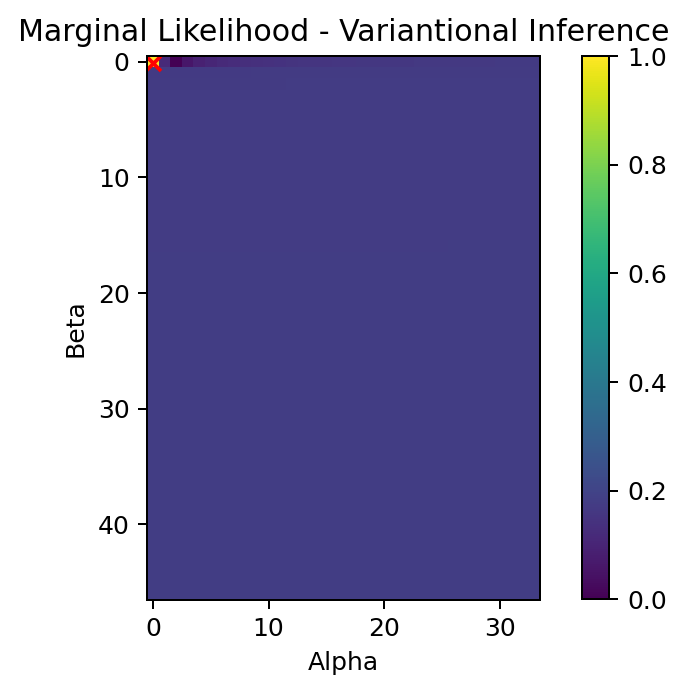

Alpha 0.011949038741180229
Beta 0.11022372706770484


In [25]:

z_var_inf = np.array(log_track)
alpha_beta = np.array(alpha_beta_track)
x_var_inf = np.linspace(0, 10, 34)
y_var_inf = np.linspace(0, 10, 47)

plt.figure(num=None, figsize=(6, 4), dpi=180, facecolor='w', edgecolor='k')
plt.imshow(z_var_inf.reshape(47,34))
plt.scatter(alpha_estimate, beta_estimate, marker='x', c='r', label='Optimum')
plt.xlabel('Alpha')
plt.ylabel('Beta')
plt.title('Marginal Likelihood - Variantional Inference')
plt.colorbar()
plt.savefig('Var Inf Contour')
plt.show()


print('Alpha', alpha_estimate)
print('Beta', beta_estimate)
# plt.contourf(x_var_inf, y_var_inf, z_var_inf.reshape)

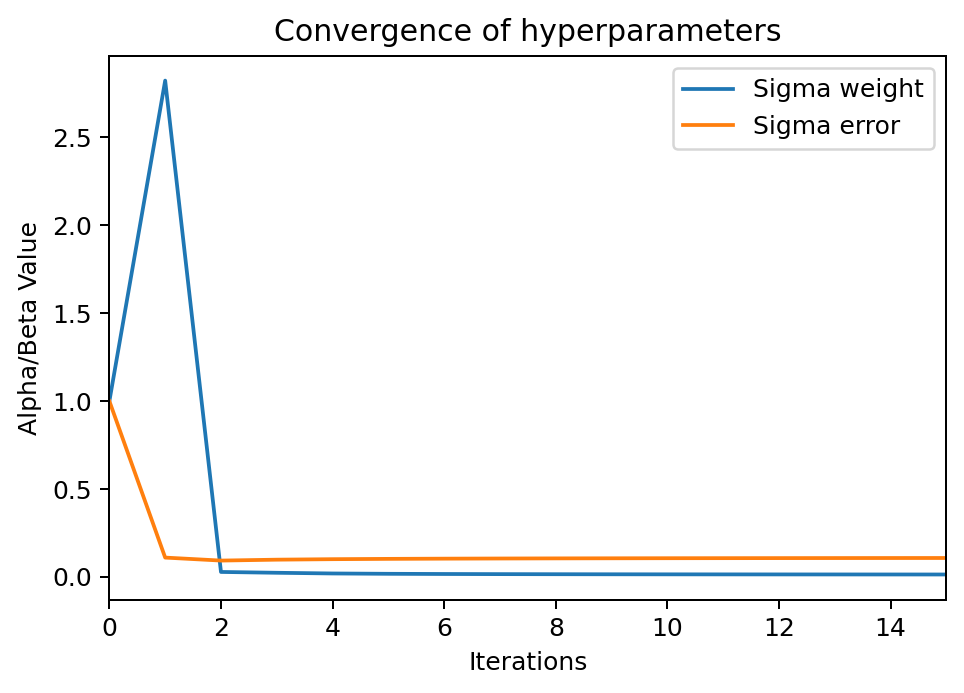

In [26]:
plt.figure(num=None, figsize=(6, 4), dpi=180, facecolor='w', edgecolor='k')
plt.plot(alpha_beta[:,0], label='Sigma weight')
plt.plot(alpha_beta[:,1], label='Sigma error')
plt.legend()
plt.title('Convergence of hyperparameters')
plt.xlabel('Iterations')
plt.ylabel('Alpha/Beta Value')
plt.xlim(0, 15)
plt.savefig('Convergence of hyperparameters')
plt.show()

In [27]:
def E(A, u0, v0, u, v):
    """Total energy."""
    return (u0 @ tau @ u0 + v0 @ v0) - (u @ tau @ u + v @ v)

In [28]:
def leapfrog(A, u, v, h, N):
    """Leapfrog finite difference scheme."""
    v = v - h/2 * A @ u
    for i in range(N-1):
        u = u + h * v
        v = v - h * A @ u

    u = u + h * v
    v = v - h/2 * A @ u

    return u, v

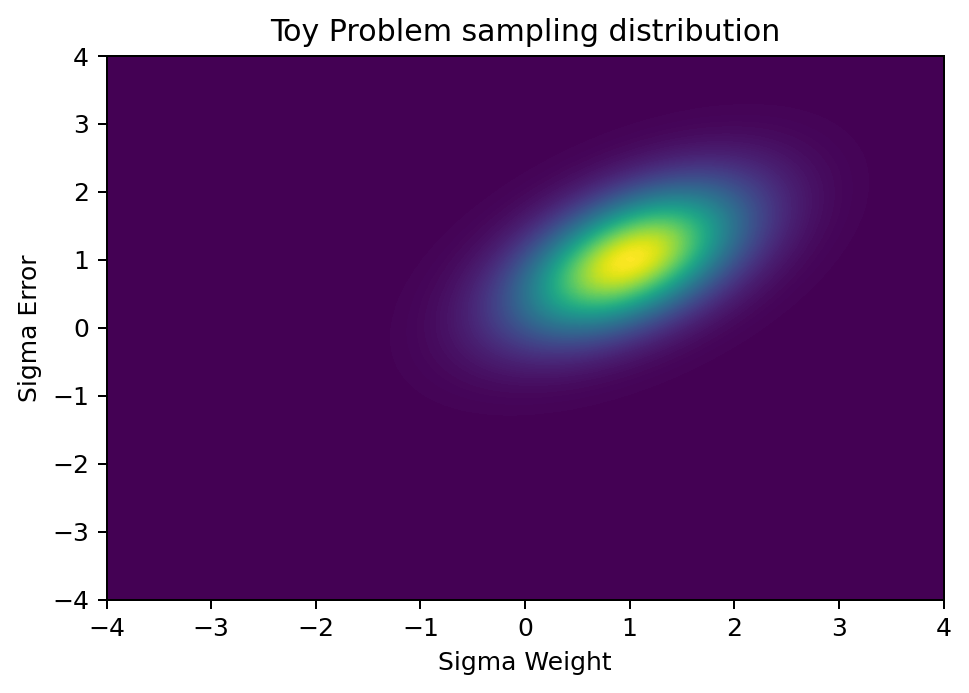

In [45]:
x_toy = np.linspace(-4, 4, 100)
y_toy = np.linspace(-4, 4, 100)
X_toy, Y_toy = np.meshgrid(x_toy, y_toy)
pos_toy = np.dstack((X_toy, Y_toy))
sigma_toy = np.array([[0.5,0.25],[0.25,0.5]])
mu_toy = np.ones(2)

y_toy = stats.multivariate_normal(mu_toy, sigma_toy)
z_toy = y_toy.pdf(pos_toy)
plt.figure(num=None, figsize=(6, 4), dpi=180, facecolor='w', edgecolor='k')
plt.contourf(X_toy, Y_toy, z_toy.reshape(100,100), 200)
plt.title('Toy Problem sampling distribution')
plt.xlabel('Sigma Weight')
plt.ylabel('Sigma Error')
# plt.axis([-3.5,3.5,-3.5,3.5])
plt.savefig('Toy Problem Distribution')
plt.show()

In [30]:
niter = 100
h = 0.01
N = 100
# A = np.array([0,1], [-tau, ])

tau = np.linalg.inv(sigma_toy)

orbit = np.zeros((niter+1, 2))
u = np.array([-2,0])
orbit[0] = u
for k in range(niter):
    v0 = np.random.normal(0,1,2)
    u, v = leapfrog(tau, u, v0, h, N)
    
    # accept-reject
    u0 = orbit[k]
    a = np.exp(E(tau, u0, v0, u, v))
    r = np.random.rand()

    if r < a:
        orbit[k+1] = u
    else:
        orbit[k+1] = u0

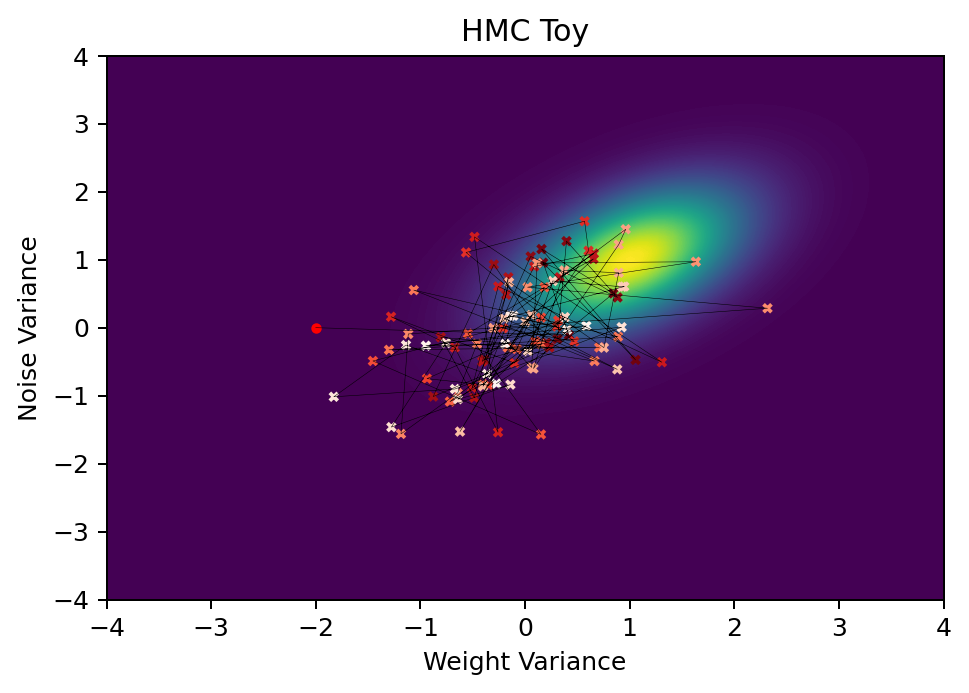

In [31]:
s=10
plt.figure(num=None, figsize=(6, 4), dpi=180, facecolor='w', edgecolor='k')
plt.contourf(X_toy, Y_toy, z_toy, 200)
plt.plot(orbit[:,0], orbit[:,1], c='k', linewidth=0.2)
plt.scatter(orbit[:1,0], orbit[:1,1],  c='red', s=s)
plt.scatter(orbit[1:,0], orbit[1:,1],  c=np.arange(niter)[::-1], cmap='Reds', s=s, marker='x')
plt.title('HMC Toy')
plt.xlabel('Weight Variance')
plt.ylabel('Noise Variance')
plt.savefig('HMC Toy')
# plt.axis([-3.5,3.5,-3.5,3.5])


In [32]:
orbit[-1]

array([-0.27297311, -0.82362526])

# HMC on Heat set


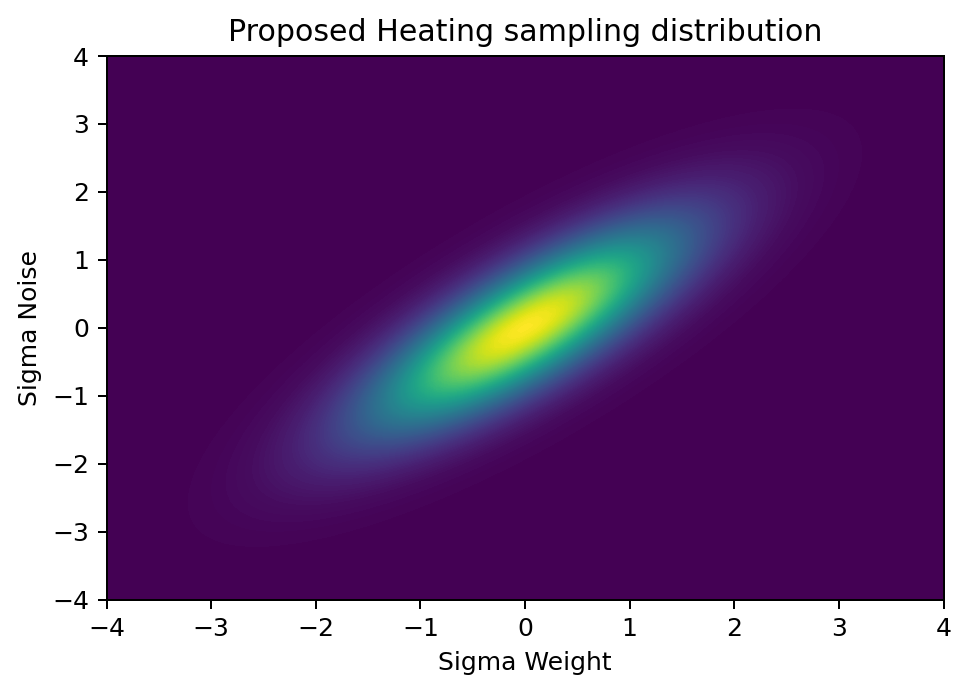

In [47]:
x_actual = np.linspace(-4, 4, 100)
y_actual = np.linspace(-4, 4, 100)
X_actual, Y_actual = np.meshgrid(x_actual, y_actual)
pos_actual = np.dstack((X_actual, Y_actual))

sigma_actual = np.array([[1,0.8],[0.8,1]])
mu_actual = np.zeros(2)

y_actual = stats.multivariate_normal(mu_actual, sigma_actual)
z_actual = y_actual.pdf(pos_actual)
plt.figure(num=None, figsize=(6, 4), dpi=180, facecolor='w', edgecolor='k')
plt.contourf(X_actual, Y_actual, z_actual.reshape(100 ,100), 200)
plt.xlabel('Sigma Weight')
plt.ylabel('Sigma Noise')
plt.title('Proposed Heating sampling distribution')
# plt.axis([-3.5,3.5,-3.5,3.5])
plt.savefig('Proposed Sampling distribution')
plt.show()


In [34]:
niter = 100
h = 0.01
N = 100
# A = np.array([0,1], [-tau, ])

tau = np.linalg.inv(sigma_actual)

orbit = np.zeros((niter+1, 2))
u = np.array([-3,3])
orbit[0] = u
for k in range(niter):
    v0 = np.random.normal(0,1,2)
    u, v = leapfrog(tau, u, v0, h, N)
    
    # accept-reject
    u0 = orbit[k]
    a = np.exp(E(tau, u0, v0, u, v))
    r = np.random.rand()

    if r < a:
        orbit[k+1] = u
    else:
        orbit[k+1] = u0

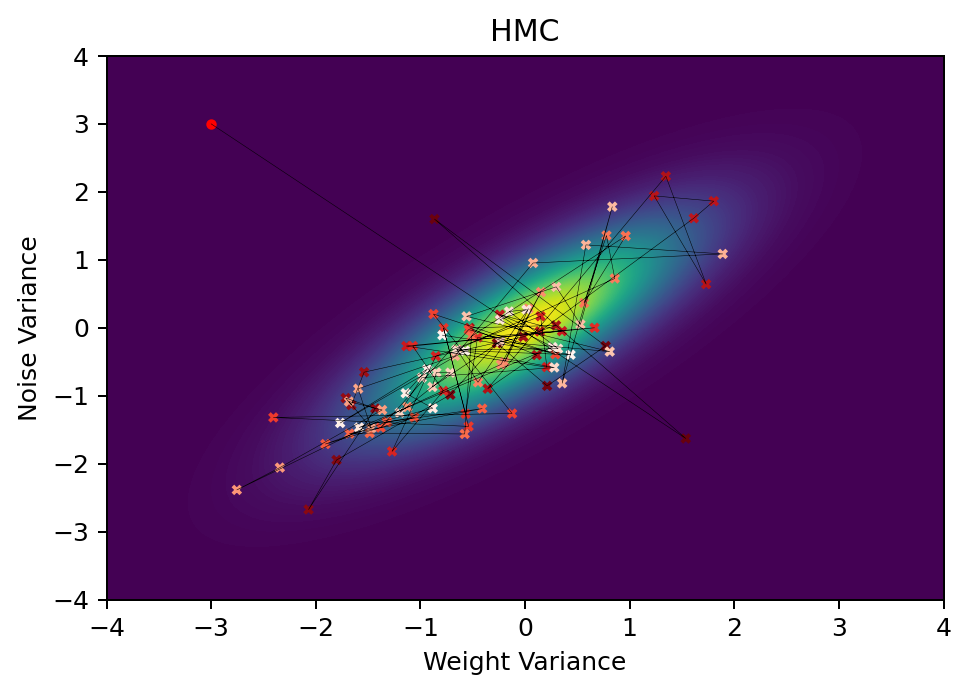

In [35]:
s=10
plt.figure(num=None, figsize=(6, 4), dpi=180, facecolor='w', edgecolor='k')
plt.contourf(X_actual, Y_actual, z_actual, 200)
plt.plot(orbit[:,0], orbit[:,1], c='k', linewidth=0.2)
plt.scatter(orbit[:1,0], orbit[:1,1],  c='red', s=s)
plt.scatter(orbit[1:,0], orbit[1:,1],  c=np.arange(niter)[::-1], cmap='Reds', s=s, marker='x')
plt.title('HMC')
plt.xlabel('Weight Variance')
plt.ylabel('Noise Variance')
plt.savefig('HMC Heating')
plt.show()


In [36]:
mu_hmc, _ = compute_posterior(x_train_norm, y_train, orbit[-1][0], orbit[-1][1])
mu_hmc

array([[22.91554073],
       [-6.99097638],
       [-3.77464815],
       [ 0.7946461 ],
       [-4.08544979],
       [ 7.27705844],
       [-0.12587542],
       [ 2.77100443],
       [ 0.20302571]])

In [37]:
rmse_hmc_test = np.sqrt(np.mean((x_test_norm @ mu_hmc - y_test)**2))
rmse_hmc_train = np.sqrt(np.mean((x_train_norm @ mu_hmc - y_train)**2))

In [51]:
print(rmse_hmc_test, rmse_hmc_train)

2.8434388867277245 3.0116448250675085


# Bonus 

In [52]:
y_train_binary = np.where(y_train < 23, 1, 0)
val, count = np.unique(y_train_binary, return_counts=True)
import lab4_hmc as hmc

In [53]:
def e_func(beta, x, y, sig_beta):
    lgp = sum((beta**2)/(2*sig_beta**2)) - sum((y * x @ beta) - np.log(1 + np.exp(x @ beta)))
    return -lgp

def e_grad(beta, x, y, sig_beta):
    g = np.empty(9)
    for rna in range(len(x[0])):
#         ua = sum(x[:,rna] * (y[rna] - ((np.exp(x[rna] @ beta))/(1 + np.exp(x[rna] @ beta)))))
#         eq = beta[rna]/np.square(sig_beta)
        
        g[rna] = (beta[rna]/sig_beta**2) - sum((y[rna] - (np.exp(x[rna] @ beta))/(1 + np.exp(x[rna] @ beta))))
#     g = g.reshape(9,)
        
    return g

In [62]:
beta = np.linspace(0,1,9).reshape(9,1)
sig_beta = 1
y = y_train_binary
# x0 = x_train_norm
R = 1000
L = 20
eps = 0.01
burn = int(R/10)
S, *_ = hmc.sample(beta, e_func, e_grad, R, L, eps, burn=burn, checkgrad=True, args=[x_train_norm, y, sig_beta])

Calc.         Numeric       Delta         Acc.
   -0.339808      -5.86449  -5.524686e+00   1
    0.255705      -139.861  -1.401163e+02   1
    0.769237       146.423   1.456535e+02   1
    0.639561      -77.9014  -7.854100e+01   1
     1.43569        180.22   1.787844e+02   1
    0.140818      -187.452  -1.875932e+02   1
    0.190674      -61.0012  -6.119184e+01   1
     1.21357      -91.0812  -9.229479e+01   1
    0.161538      -89.0042  -8.916578e+01   1
|----------|  0% accepted [ 4 secs to go ]
|#---------| 27% accepted [ 4 secs to go ]
|##--------| 24% accepted [ 4 secs to go ]
|###-------| 20% accepted [ 3 secs to go ]
|####------| 18% accepted [ 3 secs to go ]
|#####-----| 16% accepted [ 3 secs to go ]
|######----| 15% accepted [ 2 secs to go ]
|#######---| 14% accepted [ 2 secs to go ]
|########--| 13% accepted [ 1 secs to go ]
|#########-| 12% accepted [ 1 secs to go ]
|##########| 11% accepted [ 0 secs to go ]
HMC: R=1000 / L=20 / eps=0.01 / Accept=11.2%


In [63]:
rmse_track = np.empty(len(S))
for r in range(len(S)):
    rmse_track[r] =  np.sqrt(np.mean((x_test_norm @ S[r]  - y_test)**2))


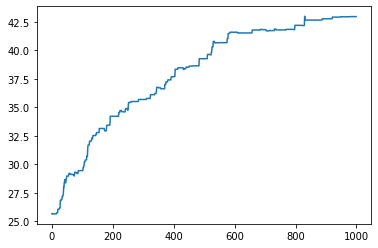

In [64]:
plt.plot(rmse_track)